In [1]:
# The following is the API download the vit_t16 model trained on ImageNet dataset
from akida_models import fetch_file
from akida_models.model_io import load_model

# Retrieve the float model with pretrained weights and load it
model_file = fetch_file(
    fname="bc_vit_ti16_224.h5",
    origin="https://data.brainchip.com/models/AkidaV2/vit/bc_vit_ti16_224.h5",
    cache_subdir='models/akidanet_imagenet')
model_keras = load_model(model_file)
model_keras.summary()

23695632/23695632 [==============================] - 8s 0us/step
Download complete.


C:\Users\msaad\AppData\Roaming\Python\Python38\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "vit-tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Rescale (Rescaling)            (None, 224, 224, 3)  0           ['input[0][0]']                  
                                                                                                  
 Embedding (Conv2D)             (None, 14, 14, 192)  147648      ['Rescale[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 196, 192)     0           ['Embedding[0][0]']       

In [2]:
# Using QuantizeML to perform quantization
from quantizeml.models import quantize, QuantizationParams

# Define the quantization parameters.
qparams = QuantizationParams(weight_bits=8, activation_bits=8)

# Quantize the model defined in Section 3.2
model_quantized = quantize(model_keras, qparams=qparams)
model_quantized.summary()

C:\Users\msaad\AppData\Roaming\Python\Python38\site-packages\quantizeml\models\quantize.py:449: UserWarning: Quantizing per-axis with random calibration samples is not accurate.                       Set QuantizationParams.per_tensor_activations=True when calibrating with                        random samples.
  warnings.warn("Quantizing per-axis with random calibration samples is not accurate.\


1024/1024 [==============================] - 44s 38ms/step
Model: "vit-tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Rescale (QuantizedRescaling)   (None, 224, 224, 3)  0           ['input[0][0]']                  
                                                                                                  
 Embedding (QuantizedConv2D)    (None, 14, 14, 192)  147648      ['Rescale[0][0]']                
                                                                                                  
 reshape (QuantizedReshape)     

In [3]:
from akida_models import bc_vit_ti16_imagenet_pretrained

# Load the pre-trained quantized model
model_quantized = bc_vit_ti16_imagenet_pretrained()
model_quantized.summary()

24413248/24413248 [==============================] - 8s 0us/step
Download complete.
Model: "vit-tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Rescale (QuantizedRescaling)   (None, 224, 224, 3)  0           ['input[0][0]']                  
                                                                                                  
 Embedding (QuantizedConv2D)    (None, 14, 14, 192)  147648      ['Rescale[0][0]']                
                                                                                                  
 reshap

In [4]:
from cnn2snn import convert

# Convert the model
model_akida = convert(model_quantized)
model_akida.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [1, 1, 1000]  1          14    
________________________________________________

_______________________________________________________________________
Layer (type)                          Output shape   Kernel shape    

================= SW/Embedding-dequantizer (Software) =================

Embedding (Stem)                      [1, 197, 192]  (16, 16, 3, 192)
_______________________________________________________________________
VitEncoderBlock_2 (VitEncoderBlock)   [1, 197, 192]  N/A             
  norm_mha                                           N/A             
  query                                              (192, 192)      
  key                                                (192, 192)      
  value                                              (192, 192)      
  attention                                       

In [5]:
import numpy as np
from akida_models.imagenet import get_preprocessed_samples

# Model specification and hyperparameters
NUM_CHANNELS = 3
IMAGE_SIZE = 224

NUM_IMAGES = 10

# Load the preprocessed images
x_test, _ = get_preprocessed_samples(IMAGE_SIZE, NUM_CHANNELS)

print(f'{NUM_IMAGES} images loaded and preprocessed.')

10 images loaded and preprocessed.


1/1 [==============================] - 41s 41s/step


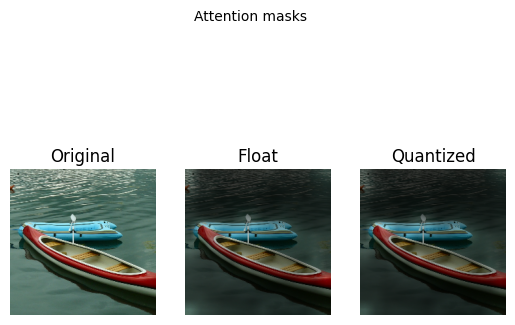

In [6]:
import cv2
import matplotlib.pyplot as plt

from keras import Model
from quantizeml.layers import ClassToken, Attention
from quantizeml.tensors import FixedPoint
from quantizeml.models.transforms.transforms_utils import get_layers_by_type


def build_attention_map(model, image):
    # Get the Attention layers list
    attentions = get_layers_by_type(model, Attention)

    # Calculate the number of tokens and deduce the grid size
    num_tokens = sum(isinstance(ly, ClassToken) for ly in model.layers)
    grid_size = int(np.sqrt(attentions[0].output_shape[0][-2] - num_tokens))

    # Get the attention weights from each transformer
    outputs = [la.output[1] for la in attentions]
    weights = Model(inputs=model.inputs, outputs=outputs).predict(np.expand_dims(image, 0))

    # Converts to float if needed
    weights = [w.to_float() if isinstance(w, FixedPoint) else w for w in weights]
    weights = np.array(weights)

    # Heads number
    num_heads = weights.shape[2]
    num_layers = weights.shape[0]
    reshaped = weights.reshape((num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1))

    # Average the attention weights across all heads
    reshaped = reshaped.mean(axis=1)

    # To account for residual connections, we add an identity matrix to the attention matrix and
    # re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[..., np.newaxis]
    return (mask * image).astype("uint8")


# Using a specific image for which attention map is easier to observe
image = x_test[8]

# Compute the attention map
attention_float = build_attention_map(model_keras, image)
attention_quantized = build_attention_map(model_quantized, image)

# Display the attention map
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.axis('off')
ax1.set_title('Original')
ax1.imshow(image)

ax2.axis('off')
ax2.set_title('Float')
ax2.imshow(attention_float)

ax3.axis('off')
ax3.set_title('Quantized')
ax3.imshow(attention_quantized)
fig.suptitle('Attention masks', fontsize=10)
plt.show()